In [3]:
%matplotlib inline

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.ops import unary_union

from copy import deepcopy
import math

# Triangular weave
This code will make a diamond shaped unit that can be tiled to make a triangular weave pattern.

In [201]:
class Triangular_Weave():
    
    """
    Class to store the properties of a triangular weave tile that can be repeated in a diamond
    pattern.

    Members
    -------
        W, S, L: width, spacing, and length of exposed ribbons
        shapes: a list of shapely.geometry.Polygons forming the weave
        labels: a list of labels for the shapes
        tile_box: a diamond Polygon that exactly contains a primitive cell
        translations: the translations that define the tiling
    """
    def __init__(self, width = 1, spacing = 3, 
                 labels = ["A", "B", "C"], 
                 margin = 0):
        """
        Class constructor, parameters as above except:
        margin: an inset margin to give a spacing effect where ribbons seem to over-under one another
        """
        self.W = width
        self.S = spacing
        self.L = self.S - self.W
        self.translations = [(0, 0),
                             (self.S / 2, -self.S * math.sqrt(3) / 2),
                             (self.S, 0),
                             (self.S / 2, self.S * math.sqrt(3) / 2)]
        self.tile_box = self.get_tile_box()
        self.shapes, self.labels = self.get_shapes_and_labels(labels, margin)
        
    
    def get_shapes_and_labels(self, labels, m):
        """
        Returns the list of shapes and labels
        """
        # base parallelogram
        base_p = Polygon([(0, 0), 
                          (self.L, 0), 
                          (self.L - self.W / 2, self.W * math.sqrt(3) / 2), 
                          (-self.W / 2, self.W * math.sqrt(3) / 2)]).buffer(-m, cap_style = 2)
        
        # make 3 copies at 120 degree rotations, and also apply the translation vectors
        base_ew = [translate(deepcopy(base_p), t[0], t[1]) for t in self.translations]
        base_swne = [translate(rotate(deepcopy(base_p), -120, (0, 0)), t[0], t[1]) for t in self.translations]
        base_nwse = [translate(rotate(deepcopy(base_p), 120, (0, 0)), t[0], t[1]) for t in self.translations]
        
        # make full list of all shapes and corresponding labels
        shps = base_ew + base_swne + base_nwse
        lbls = labels[0] * 4 + labels[1] * 4 + labels[2] * 4
        # empty lists for final result
        shapes = []
        labels = []
        # now test if they intersect the primitive cell and if so retain that
        # discarding point intersections
        for p, l in zip(shps, lbls):
            if self.tile_box.intersects(p):
                prototile = p.intersection(self.tile_box)
                if isinstance(prototile, Polygon):
                    shapes.append(prototile)
                    labels.append(l)
        return (shapes, labels)
        
        
    def get_tile_box(self):
        """
        Bounding polygon is a diamond with dimensions dependendent on the spacings and numbers of ribbons
        """
        return Polygon(self.translations)
    
    

    def get_primitive_cell(self):
        """
        Make and return a Primitive_Cell from the shapes and bounding shape
        """
        c_bb = self.tile_box.centroid
        c_unit = unary_union(self.shapes).centroid
        types = ["bounding_polygon"]
        shapes = [self.tile_box]
        labels = ["bb"]
        for s, label in zip(self.shapes, self.labels):
            shapes.append(s)
            labels.append(label)
            types.append("shape")
        return geopandas.GeoDataFrame(data = {"label": labels, "type": types},
                                      geometry = geopandas.GeoSeries(shapes))

<AxesSubplot:>

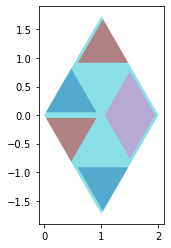

In [206]:
w = Triangular_Weave(spacing = 2, margin = 0.05)

tile = w.get_primitive_cell()
tile.plot(column = "label", alpha = 0.5)

In [172]:
tile.to_file("tile.geojson", driver = "GeoJSON")